# EN3160 Assignment 2 
# Fitting and Alignment

* Index No : 210095FU

* Name : D.M.T.K.R DASSANAYAKE

## Question 1


Largest Circle Parameters:
Radius: 72.40773439350254
Center Coordinates (x, y): (98, 884)

Range of σ values used:
Minimum σ: 0.4
Maximum σ: 51.200000000000045


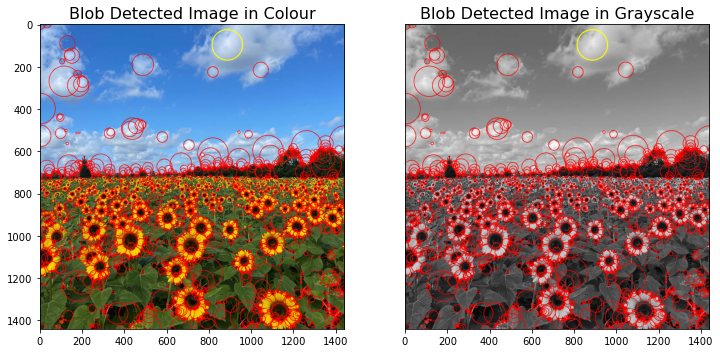

In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt



# Function Definitions

def log_kernel(sigma, size):

        if size % 2 == 0:  # Size must be odd
                size = size + 1

        sigma2 = sigma ** 2  # Sigma squared
        idx_range = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)  # Index range 
        x_idx, y_idx = np.meshgrid(idx_range, idx_range)  # Meshgrid of index range
        tmp_cal = -(np.square(x_idx) + np.square(y_idx)) / (2. * sigma2)  # Calculate the exponential term
        kernel = np.exp(tmp_cal)  # Computes the Gaussian kernel
        kernel[kernel < np.finfo(float).eps * np.amax(kernel)] = 0  # Discards very small numbers
        k_sum = np.sum(kernel)  # Sums all the elements in the kernel

        if k_sum != 0:
                kernel /= np.sum(kernel)  # Normalizes the kernel

        tmp_kernel = np.multiply(kernel, np.square(x_idx) + np.square(y_idx) - 2 * sigma2) / (sigma2 ** 2)  # Computes the Laplacian component of the LoG filter
        kernel = tmp_kernel - np.sum(tmp_kernel) / (size ** 2) # Final LoG filter
        return kernel


def show_kernel(kernel):
        plt.imshow(kernel, cmap='viridis')
        plt.colorbar()
        plt.title('Kernel')
        plt.show()




# Image name
img_name = "the_berry_farms_sunflower_field"

# Full file path
image_path = r'D:\UoM\sem 5\Image Processing\Assignments\Assignment 2\Assignment 2\2024\\' + img_name + ".jpeg"

# Read the image
img = cv.imread(image_path)

# Convert the image to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = np.float32(gray)  # Change the data type to float32 for processing
cv.normalize(gray, gray, 1, 0, cv.NORM_MINMAX)  # Normalize the grayscale image

# Define initial sigma, scale factor, and the number of scales
sigma0 = 0.4  # Starting sigma value (selected empirically)
k = np.sqrt(2)  # Scaling factor for sigma
num_scales = 15  # Number of scales to analyze
sigmas = sigma0 * np.power(k, np.arange(num_scales))  # Array of sigma values for each scale

# Apply Laplacian of Gaussian (LoG) filtering at multiple scales
img_stack = None
for i in range(num_scales):
        size = int(2 * np.ceil(4 * sigmas[i]) + 1)  # Calculate kernel size based on sigma
        kernel = log_kernel(sigmas[i], size) * np.power(sigmas[i], 2)  # Generate LoG kernel
        #show_kernel(kernel)  # (Optional) Display the kernel for visualization
        
        filtered = cv.filter2D(gray, cv.CV_32F, kernel)  # Apply LoG filter to the image
        filtered = pow(filtered, 2)  # Square the filtered result for stability
        
        # Stack the filtered results across scales
        if i == 0:
                img_stack = filtered
        else:
                img_stack = np.dstack((img_stack, filtered))

# Perform maximum response extraction
scale_space = None
for i in range(num_scales):
        filtered = cv.dilate(img_stack[:, :, i], np.ones((3, 3)), cv.CV_32F, (-1, -1), 1, cv.BORDER_CONSTANT)  # Dilate the filtered image
        
        # Stack the dilated images across scales
        if i == 0:
                scale_space = filtered
        else:
                scale_space = np.dstack((scale_space, filtered))

# Identify the maximum response across all scales
max_stack = np.amax(scale_space, axis=2)  # Find the maximum response at each pixel across scales
max_stack = np.repeat(max_stack[:, :, np.newaxis], num_scales, axis=2)  # Create a 3D stack with the maximum response image replicated for each scale
max_stack = np.multiply((max_stack == scale_space), scale_space)  # Retain only the maximum responses

# Initialize vectors for storing blob information (coordinates and radius)
radius_vec = None
x_vec = None
y_vec = None

# Extract blob coordinates and radii
for i in range(num_scales):
        radius = np.sqrt(2) * sigmas[i]  # Compute the blob radius for the current scale
        threshold = 0.01  # Threshold to filter weaker responses
        valid = (max_stack[:, :, i] == img_stack[:, :, i]) * img_stack[:, :, i]  # Retain valid maxima only
        valid[valid <= threshold] = 0  # Zero out values below the threshold
        (x, y) = np.nonzero(valid)  # Get the coordinates of the valid blobs
        
        # Stack the coordinates and radii
        if i == 1:
                x_vec = x  # Store x coordinates of blobs
                y_vec = y  # Store y coordinates of blobs
                radius_vec = np.repeat(radius, np.size(x))  # Store radii of blobs
        else:
                x_vec = np.concatenate((x_vec, x), axis=None)  # Concatenate x coordinates across scales
                y_vec = np.concatenate((y_vec, y), axis=None)  # Concatenate y coordinates across scales
                tmp_vec = np.repeat(radius, np.size(x))  # Create radius vector
                radius_vec = np.concatenate((radius_vec, tmp_vec), axis=None)  # Concatenate radii

# Find the largest blob
max_radius = np.max(radius_vec)  # Maximum radius
max_circle_idx = np.argmax(radius_vec)  # Index of the largest blob
max_x = x_vec[max_circle_idx]  # X coordinate of the largest blob
max_y = y_vec[max_circle_idx]  # Y coordinate of the largest blob

# Print parameters of the largest blob
print(f"\nLargest Circle Parameters:")
print(f"Radius: {max_radius}")
print(f"Center Coordinates (x, y): ({max_x}, {max_y})")

# Report the range of sigma values used
min_sigma = np.min(sigmas)
max_sigma = np.max(sigmas)
print(f"\nRange of σ values used:")
print(f"Minimum σ: {min_sigma}")
print(f"Maximum σ: {max_sigma}")

# Prepare the output images
out = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # Convert to grayscale
out = cv.cvtColor(out, cv.COLOR_GRAY2BGR)  # Convert grayscale back to BGR

out_colour = img.copy()  # Copy of the original image for coloring blobs
out_grayscale = out.copy()  # Grayscale version for coloring blobs

# Draw the detected blobs on the output images
for i in range(np.size(x_vec)):
        if i == max_circle_idx: 
                # Draw the largest blob in yellow
                cv.circle(out_colour, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0,255,255), 3)   
                cv.circle(out_grayscale, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0,255,255), 3)  
        else:
                # Draw smaller blobs in red
                cv.circle(out_colour, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0, 0, 255), 2)  
                cv.circle(out_grayscale, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0, 0, 255), 2)  

# Save the output images
cv.imwrite("../Outputs/" + img_name + "blob_detected_COLOUR.jpeg", out_colour)
cv.imwrite("../Outputs/" + img_name + "blob_detected_GRAY.jpeg", out_grayscale)

# Display the results using matplotlib
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(out_colour, cv.COLOR_BGR2RGB))  # Display the color image with blobs
plt.title("Blob Detected Image in Colour",fontsize=16)
plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(out_grayscale, cv.COLOR_BGR2RGB), cmap='gray')  # Display the grayscale image with blobs
plt.yticks([])
plt.title("Blob Detected Image in Grayscale",fontsize=16)
plt.show()


## Question 2

**Imports**

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [10]:
def find_line_parameters_using_2_points(x1,y1,x2,y2):
        
        m = (y2-y1)/(x2-x1)
        c = y1 - m*x1
        
        a = m
        b = -1
        d = -c
        
        a_normalized = a/math.sqrt(a**2+b**2)
        b_normalized = b/math.sqrt(a**2+b**2)
        d_normalized = d/math.sqrt(a**2+b**2)
        
        return a_normalized,b_normalized,d_normalized

In [11]:
def RANSAC_line_fitting(X, iterations, threshold, min_inliers):

    best_model = None
    best_inliers = []

    for i in range(iterations):
        
        sample_indices = np.random.choice(len(X),2,replace=False)
        x1,y1 = X[sample_indices[0]]
        x2,y2 = X[sample_indices[1]]
        
        a,b,d = find_line_parameters_using_2_points(x1,y1,x2,y2)
        
        magnitude = np.sqrt(a**2 + b**2)
        a = a/magnitude
        b = b/magnitude

        distances = np.abs(a*X[:,0]+b*X[:,1]-d)

        inliers  = np.where(distances<threshold)[0]

        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model   = (a,b,d)
                best_inliers = inliers

    return best_model,best_inliers

In [12]:
def find_circle_parameters_using_3_points(x1,y1,x2,y2,x3,y3):

    mx1,my1 = (x1+x2)/2,(y1+y2)/2
    mx2,my2 = (x2+x3)/2,(y2+y3)/2

    if y2-y1 == 0:
        slope1 = 0 
    else:
        slope1 = (x2-x1)/(y2-y1)

    if y3-y2 == 0:
        slope2 = 0 
    else:
        slope2 = (x3-x2)/(y3-y2)

    x_center = (slope1*mx1-slope2*mx2+my2-my1)/(slope1-slope2)
    y_center = -slope1*(x_center-mx1)+my1

    radius = np.sqrt((x1-x_center)**2+(y1-y_center)**2)

    return x_center,y_center,radius

In [13]:
def RANSAC_circle_fitting(X,iterations,threshold,min_inliers):
    
    best_model   = None
    best_inliers = []
    
    for i in range(iterations):
        sample_indices = np.random.choice(len(X),3,replace=False)
        x1,y1 = X[sample_indices[0]]
        x2,y2 = X[sample_indices[1]]
        x3,y3 = X[sample_indices[2]]
        
        x_center,y_center,radius = find_circle_parameters_using_3_points(x1,y1,x2,y2,x3,y3)
        
        errors  = np.abs(np.sqrt((X[:,0]-x_center)**2+(X[:,1]-y_center)**2)-radius)
        
        inliers = np.where(errors<threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model   = (x_center,y_center,radius)
                best_inliers = inliers
                
    return best_model,best_inliers

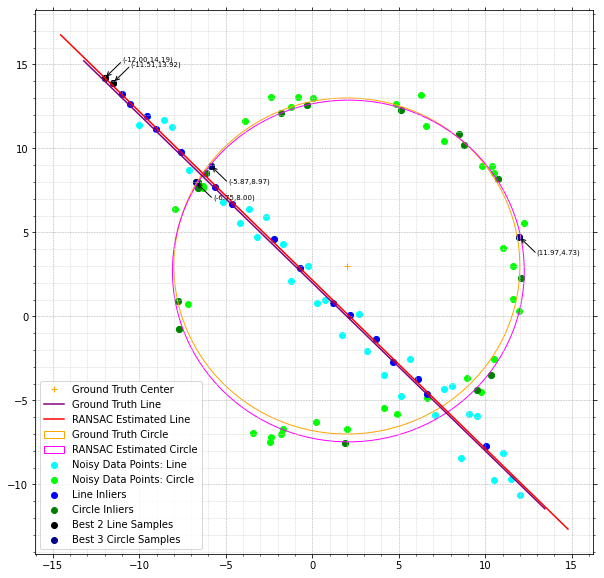

In [16]:
# Generate noisy data points corresponding to a circle and a line
np.random.seed(1)
N = 100  # Total number of data points
half_n = N // 2  # Half for the circle and half for the line
r = 10  # Radius of the circle
x0_gt, y0_gt = 2, 3  # Coordinates of the circle's center
s = r / 16  # Noise scale for the circle
t = np.random.uniform(0, 2 * np.pi, half_n)  # Random angle values for the circle points
n = s * np.random.randn(half_n)  # Random noise for the radius
x = x0_gt + (r + n) * np.cos(t)  # X coordinates of noisy circle points
y = y0_gt + (r + n) * np.sin(t)  # Y coordinates of noisy circle points
X_circ = np.column_stack((x, y))  # Stack the circle points as a 2D array

# Generate noisy points for the line
s = 1.0  # Noise scale for the line
m, b = -1, 2  # Line slope and intercept (ground truth)
x = np.linspace(-12, 12, half_n)  # X coordinates for the line
y = m * x + b + s * np.random.randn(half_n)  # Y coordinates with added noise
X_line = np.column_stack((x, y))  # Stack the line points as a 2D array

# Combine both circle and line points into a single array
X = np.vstack((X_circ, X_line))

# Create a plot for visualizing the data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Noisy Data Points: Line', color='cyan')  # Plot line points in cyan
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Noisy Data Points: Circle', color='lime')  # Plot circle points in lime green

# Plot the ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='orange', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', label='Ground Truth Center', color='orange')  # Mark the center of the circle

# Plot the ground truth line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='purple', label='Ground Truth Line')  # Plot ground truth line in purple

# RANSAC parameters for line estimation
iterations = 100000
threshold = 0.2
min_inliers = 15

# Estimate the line using RANSAC
best_RANSAC_line, line_inlier_indices_array = RANSAC_line_fitting(X_line, iterations, threshold, min_inliers)

# RANSAC parameters for circle estimation
circle_iterations = 100000
circle_threshold = 0.2
circle_min_inliers = 15

# Filter out points that belong to the line
remnant_indices = [i for i in range(len(X)) if i not in line_inlier_indices_array]
remnant_points = X[remnant_indices]

# Estimate the circle using RANSAC
best_RANSAC_circle, circle_inlier_indices_array = RANSAC_circle_fitting(remnant_points, circle_iterations, circle_threshold, circle_min_inliers)

# Plot the line estimated by RANSAC
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_RANSAC_line[0] * x_ + best_RANSAC_line[2]) / best_RANSAC_line[1]
plt.plot(x_, y_, label='RANSAC Estimated Line', color='red')  # Plot RANSAC line in red

# Plot the inliers for the line
ax.scatter(X_line[line_inlier_indices_array, 0], X_line[line_inlier_indices_array, 1], color='blue', label='Line Inliers')  # Line inliers in blue

# Select and plot the best 2 samples for the line
best_line_sample_indices = line_inlier_indices_array[:2]
best_line_samples = X_line[best_line_sample_indices]

# Plot the inliers for the circle
ax.scatter(remnant_points[circle_inlier_indices_array, 0], remnant_points[circle_inlier_indices_array, 1], color='green', label='Circle Inliers')  # Circle inliers in green

# Plot the circle estimated by RANSAC
x_center, y_center, radius = best_RANSAC_circle
circle_estimated = plt.Circle((x_center, y_center), radius, color='magenta', fill=False, label='RANSAC Estimated Circle')  # RANSAC circle in magenta
ax.add_patch(circle_estimated)

# Select and plot the best 3 samples for the circle
best_circle_sample_indices = circle_inlier_indices_array[:3]
best_circle_samples = remnant_points[best_circle_sample_indices]

# Highlight the best 2 samples for the line and the best 3 samples for the circle
ax.scatter(best_line_samples[:, 0], best_line_samples[:, 1], color='black', marker='o', label='Best 2 Line Samples')  # Best 2 line samples in black
ax.scatter(best_circle_samples[:, 0], best_circle_samples[:, 1], color='darkblue', marker='o', label='Best 3 Circle Samples')  # Best 3 circle samples in dark blue

# Function to annotate the best samples
def annotate_sample(ax, start, end, label):
        ax.annotate("", xy=start, xytext=end, arrowprops=dict(arrowstyle="->", color='black'))  # Draw black arrows
        ax.text(end[0], end[1], label, fontsize=7, ha='left')  # Annotate with coordinates

# Annotate the best samples for both the line and the circle
for i, sample in enumerate(best_line_samples):
        label = f'({sample[0]:.2f},{sample[1]:.2f})'
        annotate_sample(ax, (sample[0], sample[1]), (sample[0] + 1, sample[1] + 1), label)
for i, sample in enumerate(best_circle_samples):
        label = f'({sample[0]:.2f},{sample[1]:.2f})'
        annotate_sample(ax, (sample[0], sample[1]), (sample[0] + 1, sample[1] - 1), label)

# Set up plot grid and appearance
ax.tick_params(which='both', top=True, bottom=True, left=True, right=True)
ax.minorticks_on()  # Enable minor ticks
ax.grid(True, which='minor', linestyle='--', linewidth=0.5, color='lightgray')  # Minor grid in light gray
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='darkgray')  # Major grid in dark gray
plt.legend()  # Add legend
plt.show()  # Display the plot

## Question 3

Image shape: (576, 864, 3)
Flag shape: (376, 535, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Selected Points: [(501, 168), (688, 123), (486, 322), (724, 297)]
Homography matrix
 [[ 1.66111998e-01 -2.88983207e-01  5.01000000e+02]
 [-1.16903934e-01  2.44539802e-01  1.68000000e+02]
 [-2.66599873e-04 -5.12530020e-04  1.00000000e+00]]


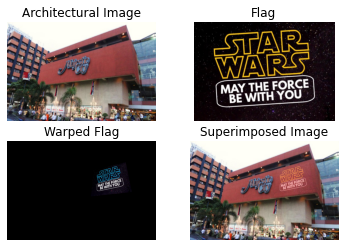

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Ensure you import matplotlib for displaying images

# Initialize a list to store the selected points
selected_points = []

# Callback function for mouse click events
def mouse_click(event, x, y, flags, param):
    global selected_points

    if event == cv2.EVENT_LBUTTONDOWN:
        selected_points.append((x, y))
        # Remove the line that draws the circle:
        # cv2.circle(architectural_image, (x, y), 4, (0, 0, 255), -1)
        # Display the image without the drawn circles
        cv2.imshow('Image', architectural_image)

architectural_image = cv.imread(r'D:\UoM\sem 5\Image Processing\Assignments\Assignment 2\Assignment 2\building\Majestic City.jpg')
flag = cv.imread(r'D:\UoM\sem 5\Image Processing\Assignments\Assignment 2\Assignment 2\building\star wars.jpg')

architectural_image = architectural_image.astype(np.float32) / np.iinfo(architectural_image.dtype).max
flag = flag.astype(np.float32) / np.iinfo(flag.dtype).max

print("Image shape:", architectural_image.shape)
print("Flag shape:", flag.shape)

cv2.imshow('Image', architectural_image)
cv2.setMouseCallback('Image', mouse_click)

# Wait for the user to select four points
while len(selected_points) < 4:
    cv2.waitKey(1)

cv2.destroyAllWindows()

print("Selected Points:", selected_points)

dst_points = np.array(selected_points).astype(np.float32)
h2, w2 = flag.shape[:2]
src_points = np.float32([[0, 0], [w2, 0], [0, h2], [w2, h2]])

H = cv2.getPerspectiveTransform(src_points, dst_points)  # Homography matrix
print('Homography matrix\n', H)

flag_warped = cv2.warpPerspective(flag, H, (architectural_image.shape[1], architectural_image.shape[0]))
superimposed_image = cv.addWeighted(architectural_image, 1, flag_warped, 0.5, 0)

# Display the images
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(architectural_image, cv2.COLOR_BGR2RGB))
plt.title('Architectural Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(flag, cv2.COLOR_BGR2RGB))
plt.title('Flag')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(flag_warped)
plt.title('Warped Flag')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(superimposed_image, cv2.COLOR_BGR2RGB))
plt.title('Superimposed Image')
plt.axis('off')

plt.show()  # Show the plots


## Question 4

In [18]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

**Functions Definitions**

In [19]:
def Find_Features(image):
    
    sift = cv.SIFT_create()
    keypoint, descriptor = sift.detectAndCompute(image, None)
    return keypoint, descriptor

In [20]:
def Find_Matches_By_Brute_Force(des1, des5):
    
    brute_force_matcher = cv.BFMatcher()
    matches = brute_force_matcher.knnMatch(des1, des5, k=2)
    return matches

In [21]:
def Process_Image(image_path):
    
    image = cv.imread(image_path)
    image_grayscale = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    sift = cv.SIFT_create()
    keypoint, descriptor = sift.detectAndCompute(image_grayscale, None)
    return image, keypoint, descriptor

In [22]:
def Calculate_Homography_Matrix(sample):
    
    M = []
    
    for i in range(len(sample)):
        x1, y1, x2, y2 = sample[i, 0], sample[i, 1], sample[i, 2], sample[i, 3]
        M.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        M.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])
        
    M = np.matrix(M)
    U, S, V = np.linalg.svd(M)
    H = np.reshape(V[-1], (3, 3))
    H = (1/H.item(8))*H
    return H

In [23]:
def Calculate_Geometric_Distance(H, correspondence):
    
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(H, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [24]:
def Final_Homography_Matrix_Using_RANSAC(corres,threshold):
    
    max_inliers = []
    homography = []
    
    for i in range(100):
        corr1 = corres[np.random.randint(0, len(corres))]
        corr2 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((corr1, corr2))
        corr3 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr3))
        corr4 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr4))
        h = Calculate_Homography_Matrix(sample)
        inliers = np.zeros((1,4))
        
        for j in range(len(corres)):
            distance = Calculate_Geometric_Distance(h, corres[j])
            if distance < 5:
                inliers = np.vstack((inliers,corres[j]))

        inliers = np.delete(inliers,0,0)

        if len(inliers) > threshold:
            max_inliers = inliers
            homography = Calculate_Homography_Matrix(max_inliers)

    return homography,max_inliers

**Displaying matches between img1 and img5**

((< cv2.DMatch 000001A2819262B0>, < cv2.DMatch 000001A282B6C810>), (< cv2.DMatch 000001A281066F30>, < cv2.DMatch 000001A281066F10>), (< cv2.DMatch 000001A2810669F0>, < cv2.DMatch 000001A281066BB0>), (< cv2.DMatch 000001A2810667F0>, < cv2.DMatch 000001A281066B30>), (< cv2.DMatch 000001A2810666F0>, < cv2.DMatch 000001A281066F50>))


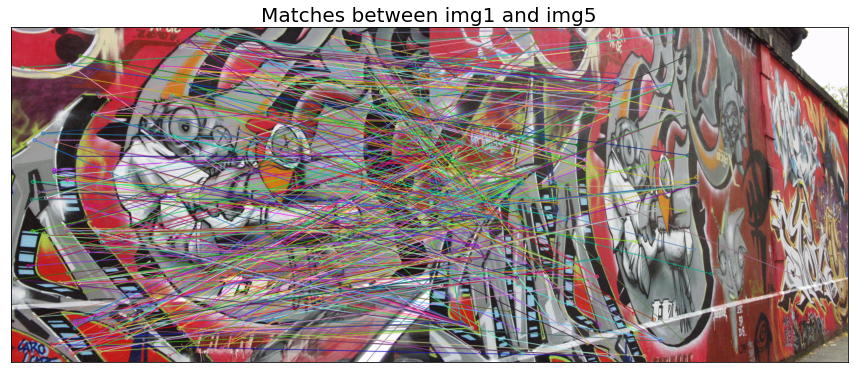

In [40]:
img1 = cv.imread('D:/UoM/sem 5/Image Processing/Assignments/Assignment 2/Assignment 2/2024/graf/img1.ppm')
img5 = cv.imread('D:/UoM/sem 5/Image Processing/Assignments/Assignment 2/Assignment 2/2024/graf/img5.ppm')

img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create()
brute_force_matcher = cv.BFMatcher()

key1, des1 = sift.detectAndCompute(img1_gray, None)
key5, des5 = sift.detectAndCompute(img5_gray, None)

matches = brute_force_matcher.knnMatch(des1, des5, k=2)
print(matches[:5])
matches = sorted(matches, key=lambda x:x[0].distance)

out_img = cv.drawMatchesKnn(img1, key1, img5, key5, matches[:200], img5, flags=2)
fig, ax = plt.subplots(figsize=(15, 8))
ax.imshow(out_img)
ax.set_xticks([])
ax.set_yticks([])
plt.title('Matches between img1 and img5', fontsize=20)
plt.show()


### Matches between all images

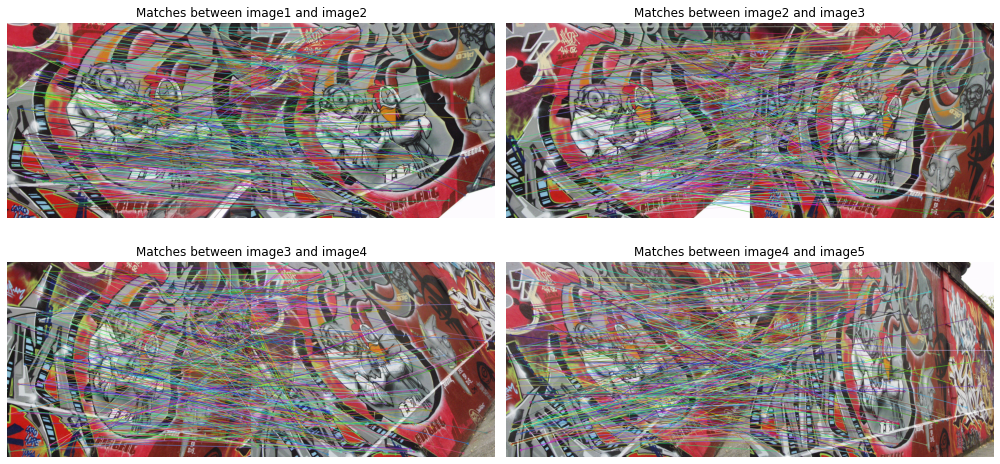

In [26]:
image_paths = ['D:/UoM/sem 5/Image Processing/Assignments/Assignment 2/Assignment 2/2024/graf/img1.ppm',
               'D:/UoM/sem 5/Image Processing/Assignments/Assignment 2/Assignment 2/2024/graf/img2.ppm',
               'D:/UoM/sem 5/Image Processing/Assignments/Assignment 2/Assignment 2/2024/graf/img3.ppm',
               'D:/UoM/sem 5/Image Processing/Assignments/Assignment 2/Assignment 2/2024/graf/img4.ppm',
               'D:/UoM/sem 5/Image Processing/Assignments/Assignment 2/Assignment 2/2024/graf/img5.ppm']

fig, axes = plt.subplots(2, 2, figsize=(14, 7))

for i in range(4):
    img1, key1, des1 = Process_Image(image_paths[i])
    img2, key2, des2 = Process_Image(image_paths[i+1])
    brute_force_matcher = cv.BFMatcher()
    matches = brute_force_matcher.knnMatch(des1, des2, k=2)
    matches = sorted(matches, key=lambda x: x[0].distance)
    out_img = cv.drawMatchesKnn(img1, key1, img2, key2, matches[:200], img2, flags=2)
    row = i // 2
    col = i % 2
    axes[row, col].imshow(out_img)
    axes[row, col].set_title(f'Matches between image{i+1} and image{i+2}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


#### Calculating the homography matrix using the defined functions

In [33]:
import cv2 as cv
import numpy as np

image_array = []

# Reading the images from the file paths
for i in range(1, 6):
    image = cv.imread(f'D:/UoM/sem 5/Image Processing/Assignments/Assignment 2/Assignment 2/2024/graf/img{i}.ppm')
    image_array.append(image)

homographs = []
threshold = 5.0  # RANSAC threshold for homography

# Initialize the SIFT detector
sift = cv.SIFT_create()

# Process pairs of images
for i in range(4):
    # Detect keypoints and descriptors in both images
    key1, des1 = sift.detectAndCompute(image_array[i], None)
    key2, des2 = sift.detectAndCompute(image_array[i+1], None)

    # Create a brute-force matcher and find matches between descriptors
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test to keep only good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Get the matching keypoints' coordinates
    src_pts = np.float32([key1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([key2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Compute homography using RANSAC
    H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, threshold)
    homographs.append(H)

# Multiply the homographies to get the final homography matrix
final_homograph = homographs[3] @ homographs[2] @ homographs[1] @ homographs[0]

# Normalize the final homography matrix
final_homograph = (1 / final_homograph[2, 2]) * final_homograph

# Print the final homography matrix and number of inliers
print('Calculated Homography\n', final_homograph)
print('Number of inliers', np.sum(mask))

# Open the correct file (either H1to5p or similar, based on the provided file structure)
with open('D:/UoM/sem 5/Image Processing/Assignments/Assignment 2/Assignment 2/2024/graf/H1to5p', 'r') as file:
    original_homography = file.read()

print('Original Homography\n', original_homography)


Calculated Homography
 [[ 6.27173521e-01  6.33046313e-02  2.21070716e+02]
 [ 2.24274380e-01  1.16183511e+00 -2.52208611e+01]
 [ 4.99597275e-04 -4.57441954e-05  1.00000000e+00]]
Number of inliers 975
Original Homography
    6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00



### Using the calculated homography matrix

(-0.5, 799.5, 639.5, -0.5)

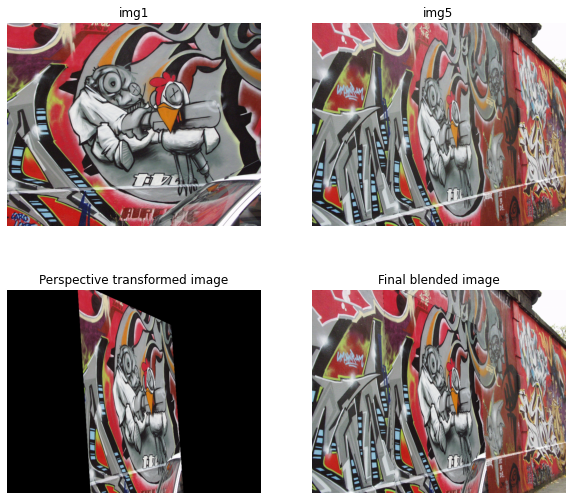

In [39]:
calculated_H = final_homograph

img1 = cv.imread('D:/UoM/sem 5/Image Processing/Assignments/Assignment 2/Assignment 2/2024/graf/img1.ppm')
img5 = cv.imread('D:/UoM/sem 5/Image Processing/Assignments/Assignment 2/Assignment 2/2024/graf/img5.ppm')

fig = plt.figure(figsize=(10, 9))
plt.subplot(2, 2, 1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('img1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('img5')
plt.axis('off')

image_perspective = cv.warpPerspective(img1, calculated_H, (img5.shape[1], img5.shape[0]))
plt.subplot(2, 2, 3)
plt.imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
plt.title('Perspective transformed image')
plt.axis('off')

threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)

plt.subplot(2, 2, 4)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
plt.title('Final blended image')
plt.axis('off')


### Using the homography matrix given in the dataset

(640, 800, 3)
(640, 800, 3)


(-0.5, 799.5, 639.5, -0.5)

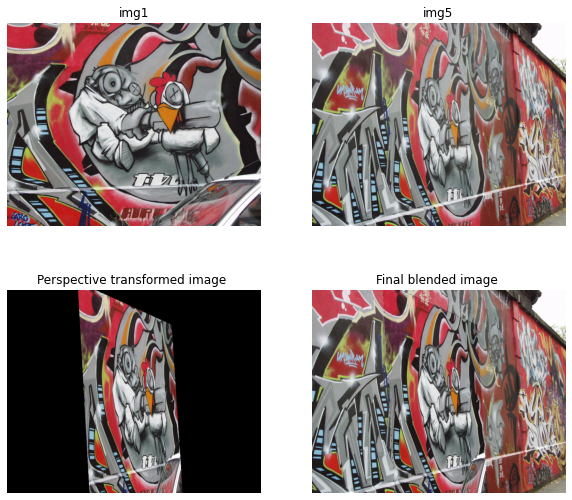

In [38]:
img1 = cv.imread('D:/UoM/sem 5/Image Processing/Assignments/Assignment 2/Assignment 2/2024/graf/img1.ppm')
img5 = cv.imread('D:/UoM/sem 5/Image Processing/Assignments/Assignment 2/Assignment 2/2024/graf/img5.ppm')

fig = plt.figure(figsize=(10, 9))
plt.subplot(2, 2, 1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('img1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('img5')
plt.axis('off')
print(img1.shape)
print(img5.shape)

h_text = open('D:/UoM/sem 5/Image Processing/Assignments/Assignment 2/Assignment 2/2024/graf/H1to5p', 'r')

original_H = []
for line in h_text:
    line = line.strip()
    line = line.split()
    line = [float(i) for i in line]
    original_H.append(line)
original_H = np.matrix(original_H)

image_perspective = cv.warpPerspective(img1, original_H, (img5.shape[1], img5.shape[0]))
plt.subplot(2, 2, 3)
plt.imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
plt.title('Perspective transformed image ')
plt.axis('off')

threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)
output_image = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
plt.subplot(2, 2, 4)
plt.imshow(output_image)
plt.title('Final blended image ')
plt.axis('off')


*****